# Flats Uncleaned Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
df = pd.read_csv('surat_uncleaned.csv')

##  DATA ASSESSMENT

In [5]:
print("Data Shape:", df.shape)

Data Shape: (4525, 11)


In [6]:
print("Data Types:", df.dtypes)

Data Types: property_name     object
areaWithType      object
square_feet       object
transaction       object
status            object
floor             object
furnishing        object
facing            object
description       object
price_per_sqft    object
price             object
dtype: object


In [7]:
print("Missing Values:", df.isnull().sum())

Missing Values: property_name        0
areaWithType         0
square_feet          0
transaction        104
status               1
floor               45
furnishing         340
facing             589
description       1371
price_per_sqft     368
price                0
dtype: int64


## DATA CLEANING

###  Clean Price Columns

In [9]:
def clean_currency(value):
    if isinstance(value, str):
        value = re.sub(r'[^\d.]', '', value)
    try:
        return float(value) * 100000 if value else np.nan 
    except:
        return np.nan

df['price'] = df['price'].apply(clean_currency)
df['price_per_sqft'] = df['price_per_sqft'].str.extract(r'(\d+,?\d+)')[0].str.replace(',', '').astype(float)

### Clean Area/Square Feet

In [10]:
df['square_feet'] = df['square_feet'].str.extract(r'(\d+)')[0].astype(float)

### Extract and Clean Floor Information

In [12]:
def clean_floor(floor):
    if pd.isna(floor):
        return np.nan
    if isinstance(floor, str):
        match = re.search(r'(\d+)\s*(?:out of|/)\s*(\d+)', floor)
        if match:
            return f"{match.group(1)}/{match.group(2)}"
    return floor

df['floor'] = df['floor'].apply(clean_floor)

### Clean Property Type from property_name

In [13]:
df['property_type'] = df['property_name'].str.extract(r'(\d+\s*BHK|Office Space|Villa)')[0]
df['property_type'] = df['property_type'].str.replace(' ', '').str.upper()

### Clean Furnishing Status

In [14]:
df['furnishing'] = df['furnishing'].str.strip().str.title()
df['furnishing'] = df['furnishing'].replace({'1': 'Unfurnished', '2': 'Semi-Furnished'})

### Clean Facing Direction

In [15]:
df['facing'] = df['facing'].str.title().str.replace('-', ' ').str.strip()
df['facing'] = df['facing'].replace({'1': 'East', '2': 'West'})

### Clean Transaction Type

In [16]:
df['transaction'] = df['transaction'].replace({'New Property': 'New', 'Resale': 'Resale'})

###  Handle Missing Values

In [17]:
df['description'].fillna('Not Available', inplace=True)
df['furnishing'].fillna('Unknown', inplace=True)
df['facing'].fillna('Unknown', inplace=True)

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\1379385158.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna('Not Available', inplace=True)
C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\1379385158.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

### Drop unnecessary columns

In [18]:
df.drop(columns=['areaWithType', 'description'], inplace=True, errors='ignore')

##  FEATURE ENGINEERING

### Create Price per SqFt 

In [19]:
df['calculated_price_per_sqft'] = df['price'] / df['square_feet']

### Extract Building Total Floors

In [21]:
df['floor_num'] = df['floor'].str.extract(r'(\d+)')[0].astype(float)

 ### Create Age Feature from Status

In [23]:
df['is_ready'] = df['status'].str.contains('Ready to Move', case=False, na=False)

### Create Luxury Flag

In [24]:
df['is_luxury'] = df['price_per_sqft'].apply(lambda x: 1 if x > 4000 else 0)

## DATA VISUALIZATION

Text(0.5, 0, 'Price (INR)')

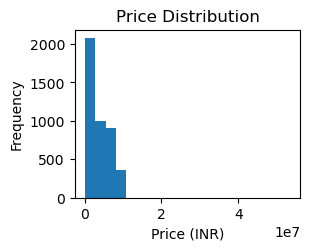

In [25]:
plt.subplot(2, 2, 1)
df['price'].plot(kind='hist', bins=20)
plt.title('Price Distribution')
plt.xlabel('Price (INR)')

Text(0, 0.5, '')

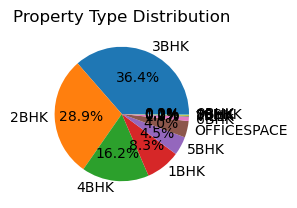

In [27]:
plt.subplot(2, 2, 3)
df['property_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Property Type Distribution')
plt.ylabel('')

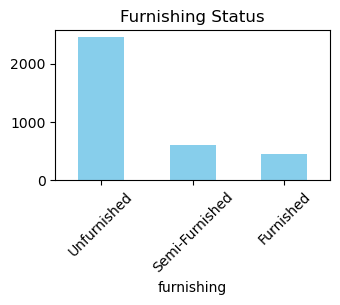

In [31]:
df['furnishing'] = df['furnishing'].str.strip().str.title()
valid_furnishings = ['Furnished', 'Semi-Furnished', 'Unfurnished']
df = df[df['furnishing'].isin(valid_furnishings)]
plt.subplot(2, 2, 4)
df['furnishing'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Furnishing Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

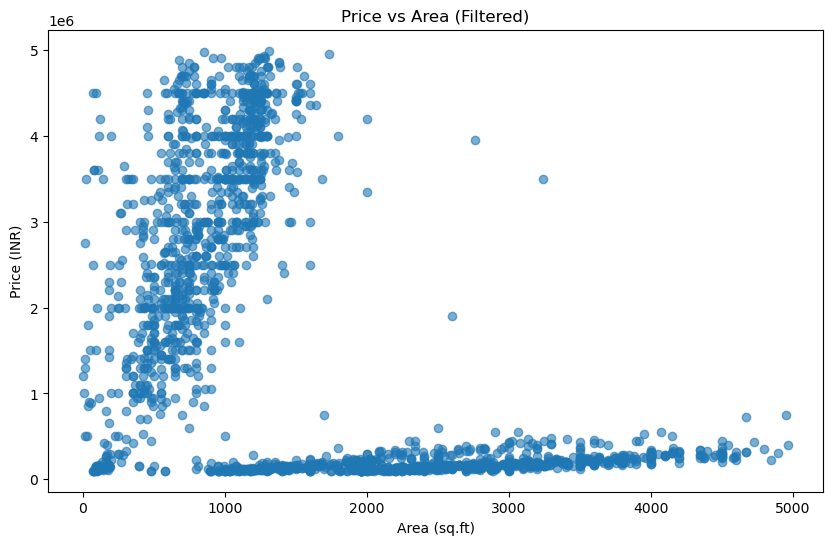

In [34]:
df_filtered = df[(df['price'] < 5e6) & (df['square_feet'] < 5000)]
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['square_feet'], df_filtered['price'], alpha=0.6)
plt.title('Price vs Area (Filtered)')
plt.xlabel('Area (sq.ft)')
plt.ylabel('Price (INR)')
plt.show()

## CATEGORICAL ENCODING & SCALING

### Label Encoding for Ordinal Features

In [35]:
label_encoders = {}
categorical_cols = ['furnishing', 'facing', 'transaction', 'status', 'property_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[col+'_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\2874013463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+'_encoded'] = le.fit_transform(df[col])
C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\2874013463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+'_encoded'] = le.fit_transform(df[col])
C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\2874013463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

###  Feature Scaling

In [38]:
scaler = StandardScaler()
numeric_cols = ['square_feet', 'price_per_sqft', 'total_floors', 'floor_num']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_19604\1257363959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# FINAL DATASET

In [39]:
print("Final Data Shape:", df.shape)

Final Data Shape: (3524, 20)


In [41]:
print("\nSample of Processed Data:") 
print(df.head())


Sample of Processed Data:
                                       property_name  square_feet  \
0          2 BHK Apartment for Sale in Dindoli Surat    -0.776566   
1           2 BHK Apartment for Sale in Althan Surat    -0.295579   
2          2 BHK Apartment for Sale in Pal Gam Surat    -0.375238   
3     2 BHK Apartment for Sale in Jahangirabad Surat    -0.734081   
4  2 BHK Apartment for Sale in Orchid Fantasia, P...    -0.316822   

       transaction            status        floor      furnishing  \
0              New  Poss. by Oct '24         5/10     Unfurnished   
1              New  Poss. by Jan '26         6/14     Unfurnished   
2           Resale     Ready to Move         5/13  Semi-Furnished   
3              New     Ready to Move         6/14     Unfurnished   
4  Orchid Fantasia      New Property  Unfurnished  Semi-Furnished   

        facing  price_per_sqft      price property_type  \
0         West       -0.624589  3380000.0          2BHK   
1  South  West       -0.4

In [42]:
df.to_csv('surat_flats_cleaned.csv', index=False)